# Performance of two decoders on Surface Code

In [1]:
import numpy as np
from panqec.codes import surface_2d
from panqec.error_models import PauliErrorModel
from panqec.decoders import MatchingDecoder, BeliefPropagationOSDDecoder
import matplotlib.pyplot as plt

In [3]:
def compute_LER(code, decoder, error_model, p, N=2000):
    n = code.n

    logical_fail = 0
    codespace_fail = 0
    total_fail = 0

    for _ in range(N):
        # 1) generate error
        error = error_model.generate(code, error_rate=p)

        # 2) calculate syndrome
        syndrome = code.measure_syndrome(error)

        # 3) decode
        correction = decoder.decode(syndrome)

        # 4) correct error
        residual = (error + correction) % 2

        # There are two kinds of errors. The way to calculate LER is borrowed from ''logical_error_rate''  in panq_function.py
        # 5) codespace error
        syn_after = code.measure_syndrome(residual)
        mse = np.any(syn_after)
        if mse:
            codespace_fail += 1

        # 6) logical error
        logical = code.logical_errors(residual)
        le = np.any(logical)
        if le:
            logical_fail += 1

        # 7) total error
        if mse or le:
            total_fail += 1

    return (logical_fail/N), (codespace_fail/N), (total_fail/N)


## Performance of MWPM (Minimum-Weight Perfect Matching) decoder

In [3]:
Distances = [3,5,7,9]
PERs = [0.06,0.07,0.08,0.09,0.10,0.12,0.14,0.16,0.18,0.2]

# We fix the error type to be X:0.34, Y:0.32, Z:0.34
error_model = PauliErrorModel(0.34, 0.32, 0.34)

Outcomes = np.zeros((len(Distances), len(PERs)))

for i, d in enumerate(Distances):
    code = surface_2d.RotatedPlanar2DCode(d)
    # Matching code may not be influenced by error_rate much, so I fixed it to 0.1.
    decoder = MatchingDecoder(code, error_model, error_rate=0.1)

    for j, p in enumerate(PERs):
        ler_x, ler_cs, ler_total = compute_LER(
            code, decoder, error_model, p, N=100000
        )
        Outcomes[i,j] = ler_total


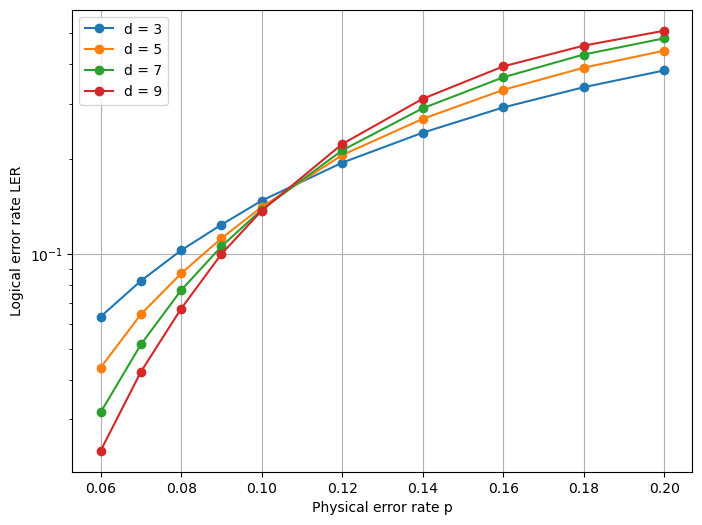

In [4]:
# plot
plt.figure(figsize=(8,6))
for i, d in enumerate(Distances):
    plt.plot(PERs, Outcomes[i], marker='o', label=f"d = {d}")

plt.xlabel("Physical error rate p")
plt.ylabel("Logical error rate LER")
plt.title("MWPM Decoder")
plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

## Performance of Belief Propogation + Ordered Statistics Decoding

In [3]:
Distances = [3,5,7,9]
PERs = [0.06,0.07,0.08,0.09,0.10,0.12,0.14,0.16,0.18,0.2]

error_model = PauliErrorModel(0.34, 0.32, 0.34)

Outcomes2 = np.zeros((len(Distances), len(PERs)))

for i, d in enumerate(Distances):
    code = surface_2d.RotatedPlanar2DCode(d)
    
    for j, p in enumerate(PERs):
        # the parameter may need to be further modified
        decoder = BeliefPropagationOSDDecoder(
            code,
            error_model,
            error_rate=p,      
            max_bp_iter=200,   
            osd_order=4,       
            bp_method='minimum_sum',  
            channel_update=True
        )
        ler_x, ler_cs, ler_total = compute_LER(
            code, decoder, error_model, p, N=100000
        )
        Outcomes2[i,j] = ler_total

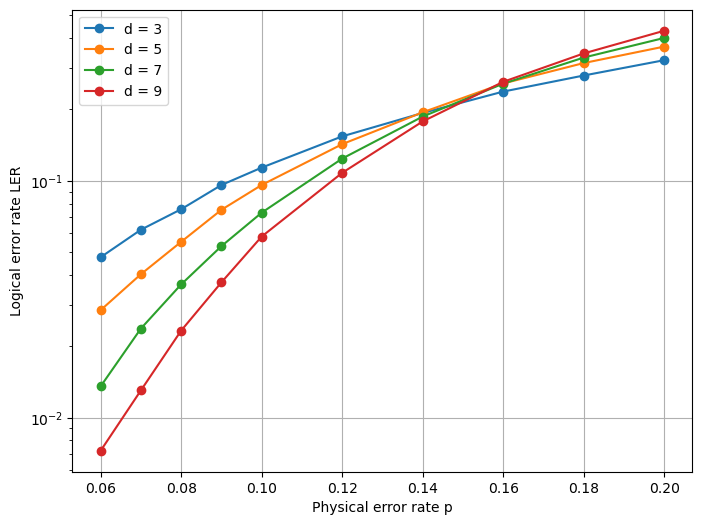

In [4]:
# 画图
plt.figure(figsize=(8,6))
for i, d in enumerate(Distances):
    plt.plot(PERs, Outcomes2[i], marker='o', label=f"d = {d}")

plt.xlabel("Physical error rate p")
plt.ylabel("Logical error rate LER")
plt.yscale("log")
plt.title("BP+OSD Decoder)
plt.legend()
plt.grid()
plt.show()